# Optimizing training and inference

In this notebook, we will discuss different ways to reduce memory and compute usage during training and inference.

## Prepare training script (1 point)

When training large models, it is usually a best practice not to use Jupyter notebooks, but run a **separate script** for training which could have command-line flags for various hyperparameters and training modes. This is especially useful when you need to run multiple experiments simultaneously (e.g. on a cluster with task scheduler). Another advantage of this is that after training, the process will finish and free the resources for other users of a shared GPU.

In this part, you will need to put all your code to train a model on Tiny ImageNet that you wrote for the previous task in `train.py`.

You can then run your script from inside of this notebook like this:

In [1]:
!python3 train.py --bs=64 --num_epochs=1 --evaluate --sched

Epoch 1 of 1 took 112.016s
  (added) training part takes 103.935s to complete
  (added) on average one batch of size 64s is processed in 0.035s
  training loss (in-iteration): 	4.661176
  validation accuracy: 			14.11 %
Evaluating on test data
Final results:
  test accuracy:		15.28 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 3064.78 Mb


**Task** 

Write code for training with architecture from homework_part2

**Requirements**
* Optional arguments from command line such as batch size and number of epochs with built-in argparse
* Modular structure - separate functions for creating data generator, building model and training 


## Profiling time (1 point)

For the next tasks, you need to add measurements to your training loop. You can use [`perf_counter`](https://docs.python.org/3/library/time.html#time.perf_counter) for that:

In [2]:
import time
import numpy as np
import pandas as pd
import torch

In [3]:
x = np.random.randn(1000, 1000)
y = np.random.randn(1000, 1000)

start_counter = time.perf_counter()
z = x @ y
elapsed_time = time.perf_counter() - start_counter
print("Matrix multiplication took %.3f seconds".format(elapsed_time))

Matrix multiplication took %.3f seconds


**Task**. You need to add the following measurements to your training script:
* How much time a forward-backward pass takes for a single batch;
* How much time an epoch takes.

## Profiling memory usage (1 point)

**Task**. You need to measure the memory consumptions

This section depends on whether you train on CPU or GPU.

### If you train on CPU
You can use GNU time to measure peak RAM usage of a script:

In [ ]:
!/usr/bin/time -lp python train.py

**Maximum resident set size**  will show you the peak RAM usage in bytes after the script finishes.

**Note**. 
Imports also require memory, do the correction

### If you train on GPU

Use [`torch.cuda.max_memory_allocated()`](https://pytorch.org/docs/stable/cuda.html#torch.cuda.max_memory_allocated) at the end of your script to show the maximum amount of memory in bytes used by all tensors.

In [4]:
x = torch.randn(1000, 1000, 1000, device='cuda:0')
print(f"Peak memory usage by Pytorch tensors: {(torch.cuda.max_memory_allocated() / 1024 / 1024):.2f} Mb")

Peak memory usage by Pytorch tensors: 3814.70 Mb


## Gradient based techniques

Modern architectures can potentially consume lots and lots of memory even for minibatch of several objects. To handle such cases here we will discuss two simple techniques.

### Gradient Checkpointing (3 points)

Checkpointing works by trading compute for memory. Rather than storing all intermediate activations of the entire computation graph for computing backward, the checkpointed part does not save intermediate activations, and instead recomputes them in backward pass. It can be applied on any part of a model.

See [blogpost](https://medium.com/tensorflow/fitting-larger-networks-into-memory-583e3c758ff9) for kind introduction and different strategies or [article](https://arxiv.org/pdf/1604.06174.pdf) for not kind introduction.

**Task**. Use [built-in checkpointing](https://pytorch.org/docs/stable/checkpoint.html), measure the difference in memory/compute 

**Requirements**. 
* Try several arrangements for checkpoints
* Add the chekpointing as the optional flag into your script
* Measure the difference in memory/compute between the different arrangements and baseline 

A bit of explanation: I created various arrangements in `train.py` script in the `CheckpointedModel` class. I was not sure whether I should present them as special cases and run some `if -> else` statements. So that's what I did. And arrangements differ in that I gradually add `checkpoint_sequential` to the network's blocks.

Why do I speak about `blocks` of the network? According to what I could find in the internet, checkpoints do not work properly with `BatchNorm` and `Dropout` layers. So what I did instead is to separate the network into blocks: each block does not have `batchnorm` or `dropout` layer, so each block represents what comes before and after those two special layers.

Below I present my results in a pandas table.

In [5]:
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched # Baseline model

Epoch 1 of 1 took 113.201s
  (added) training part takes 104.612s to complete
  (added) on average one batch of size 128s is processed in 0.012s
  training loss (in-iteration): 	4.679394
  validation accuracy: 			14.19 %
Evaluating on test data
Final results:
  test accuracy:		14.74 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5651.73 Mb


In [6]:
# Arrangement 0 is the baseline model without checkpointed, but that uses `block structure`,
# that is it is the model without checkpoints, but that is constructed using the CheckpointedModel class.
# Expectation is that it perform the same time and memory usage as the baseline one
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched --arrangement_num=0

Epoch 1 of 1 took 113.525s
  (added) training part takes 104.935s to complete
  (added) on average one batch of size 128s is processed in 0.012s
  training loss (in-iteration): 	4.648259
  validation accuracy: 			15.60 %
Evaluating on test data
Final results:
  test accuracy:		16.01 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5651.73 Mb


In [7]:
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched --arrangement_num=1

Epoch 1 of 1 took 113.517s
  (added) training part takes 104.951s to complete
  (added) on average one batch of size 128s is processed in 0.012s
  training loss (in-iteration): 	4.666649
  validation accuracy: 			14.17 %
Evaluating on test data
Final results:
  test accuracy:		15.17 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5651.73 Mb


In [8]:
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched --arrangement_num=2

Epoch 1 of 1 took 115.267s
  (added) training part takes 106.662s to complete
  (added) on average one batch of size 128s is processed in 0.013s
  training loss (in-iteration): 	4.660592
  validation accuracy: 			15.16 %
Evaluating on test data
Final results:
  test accuracy:		15.96 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5651.73 Mb


In [9]:
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched --arrangement_num=3

Epoch 1 of 1 took 116.507s
  (added) training part takes 107.948s to complete
  (added) on average one batch of size 128s is processed in 0.013s
  training loss (in-iteration): 	4.669162
  validation accuracy: 			14.52 %
Evaluating on test data
Final results:
  test accuracy:		15.64 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5494.85 Mb


In [10]:
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched --arrangement_num=4

Epoch 1 of 1 took 116.684s
  (added) training part takes 108.135s to complete
  (added) on average one batch of size 128s is processed in 0.014s
  training loss (in-iteration): 	4.675464
  validation accuracy: 			13.65 %
Evaluating on test data
Final results:
  test accuracy:		14.17 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5494.85 Mb


In [12]:
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched --arrangement_num=5

Epoch 1 of 1 took 116.729s
  (added) training part takes 108.137s to complete
  (added) on average one batch of size 128s is processed in 0.014s
  training loss (in-iteration): 	4.655618
  validation accuracy: 			15.28 %
Evaluating on test data
Final results:
  test accuracy:		16.06 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5483.24 Mb


In [13]:
# Clearly, results change from one run to another, but still stay close
results = pd.DataFrame()
results.loc['accuracy after 1 epoch on test', 'baseline'] = '14.74%'
results.loc['batch size', 'baseline'] = '128'
results.loc['time per epoch', 'baseline'] = '113.201s'
results.loc['Peak memory usage by Pytorch tensors', 'baseline'] = '5651.73 Mb'

results.loc['accuracy after 1 epoch on test', 'arrangement_0'] = '16.01%'
results.loc['batch size', 'arrangement_0'] = '128'
results.loc['time per epoch', 'arrangement_0'] = '113.525s'
results.loc['Peak memory usage by Pytorch tensors', 'arrangement_0'] = '5651.73 Mb'

results.loc['accuracy after 1 epoch on test', 'arrangement_1'] = '15.17%'
results.loc['batch size', 'arrangement_1'] = '128'
results.loc['time per epoch', 'arrangement_1'] = '113.517s'
results.loc['Peak memory usage by Pytorch tensors', 'arrangement_1'] = '5651.73 Mb'

results.loc['accuracy after 1 epoch on test', 'arrangement_2'] = '15.96%'
results.loc['batch size', 'arrangement_2'] = '128'
results.loc['time per epoch', 'arrangement_2'] = '115.267s'
results.loc['Peak memory usage by Pytorch tensors', 'arrangement_2'] = '5651.73 Mb'

results.loc['accuracy after 1 epoch on test', 'arrangement_3'] = '15.64%'
results.loc['batch size', 'arrangement_3'] = '128'
results.loc['time per epoch', 'arrangement_3'] = '116.507s'
results.loc['Peak memory usage by Pytorch tensors', 'arrangement_3'] = '5494.85 Mb'

results.loc['accuracy after 1 epoch on test', 'arrangement_4'] = '14.17%'
results.loc['batch size', 'arrangement_4'] = '128'
results.loc['time per epoch', 'arrangement_4'] = '116.684s'
results.loc['Peak memory usage by Pytorch tensors', 'arrangement_4'] = '5494.85 Mb'

results.loc['accuracy after 1 epoch on test', 'arrangement_5'] = '16.06%'
results.loc['batch size', 'arrangement_5'] = '128'
results.loc['time per epoch', 'arrangement_5'] = '116.729s'
results.loc['Peak memory usage by Pytorch tensors', 'arrangement_5'] = '5483.24 Mb'

In [14]:
results

,baseline,arrangement_0,arrangement_1,arrangement_2,arrangement_3,arrangement_4,arrangement_5
accuracy after 1 epoch on test,14.74%,16.01%,15.17%,15.96%,15.64%,14.17%,16.06%
batch size,128,128,128,128,128,128,128
time per epoch,113.201s,113.525s,113.517s,115.267s,116.507s,116.684s,116.729s
Peak memory usage by Pytorch tensors,5651.73 Mb,5651.73 Mb,5651.73 Mb,5651.73 Mb,5494.85 Mb,5494.85 Mb,5483.24 Mb


We see that as we checkpoint more layers of the network, the memoery consumption decreases. I must say that I expected it to decrease even more, so there might be a mistake somewhere in my code. Still, it is quite nice to see.

Baseline peak memory consumption is `5651 Mb` while the setting where all layers are checkpointed (apart from Batch Norm and Dropout) the peak memory consumption is `5483.24 Mb`, so we won about `200 Mb`. I wonder if I checkpointed the whole model, what would be the tradeoff between accuracy/wrong calculations in the BN and dropout layer and gains in memory consumption.  

### Accumulating gradient for large batches (3 points)
We can increase the effective batch size by simply accumulating gradients over multiple forward passes. Note that `loss.backward()` simply adds the computed gradient to `tensor.grad`, so we can call this method multiple times before actually taking an optimizer step. However, this approach might be a little tricky to combine with batch normalization. Do you see why?

**Answer**

I think accumulating gradient for large batches is tricky to combine with batch normalization for the following reason. 

From what I've read, running mean and variance are calculated each forward pass.
Then, it follows that running mean and variance will be updated for each batch, and it is different from calculating mean/variance for the `effective batch`. Simply said, updating running mean and variance 32 times for a batch size of 32 is different from updating running mean and variance from one batch of 1024 examples. Therefore, we recalculate mean and variance more frequently than update the parameters of the BN layer in the backward pass.

I guess the problem becomes clearer if we think of calculating `mean/variance` from a batch of 2 images (imagine a huge model), and `mean/variance` from, say, 10 images. The latter might be more stable and lead to faster convergence.

In [15]:
effective_batch_size = 1024
loader_batch_size = 32
batches_per_update = effective_batch_size / loader_batch_size # Updating weights after 8 forward passes

dataloader = DataLoader(dataset, batch_size=loader_batch_size)

optimizer.zero_grad()

for batch_i, (batch_X, batch_y) in enumerate(dataloader):
    l = loss(model(batch_X), batch_y)
    l.backward() # Adds gradients
  
    if (batch_i + 1) % batches_per_update == 0:
        optimizer.step()
        optimizer.zero_grad()

NameError: name 'DataLoader' is not defined

In [16]:
!python3 train.py --bs=128 --num_epochs=1 --evaluate --sched --ebs=1024

Epoch 1 of 1 took 111.352s
  (added) training part takes 102.778s to complete
  (added) on average one batch of size 128s is processed in 0.012s
  training loss (in-iteration): 	4.855658
  validation accuracy: 			11.21 %
Evaluating on test data
Final results:
  test accuracy:		11.29 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 5651.73 Mb


**Task**. Explore the trade-off between computation time and memory usage while maintaining the same effective batch size. By effective batch size we mean the number of objects over which the loss is computed before taking a gradient step.

**Requirements**

* Compare compute between accumulating gradient and gradient checkpointing with similar memory consumptions
* Incorporate gradient accumulation into your script with optional argument

It seems that accumulating gradient does not reduce memory consumption when compared with the baseline model or checkpointing, when the batch size is actually as large as used in the baseline model (in my case, `batch size = 128`. I think it makes sense, because in the code the only change is that we make a step only once in `effective_batch_size / loader_batch_size` forward passes. 

However, when it start to be interesting and important, and that's the idea of accumulating gradients is when we use a lower batch size, than used in the baseline model. See below, when I changed to batch size of 64, but still effective_batch_size = 1024. 

It becomes important when training huge models when, for example, only one image can fit into batch.

In [1]:
!python3 train.py --bs=64 --num_epochs=1 --evaluate --sched --ebs=1024

Epoch 1 of 1 took 107.471s
  (added) training part takes 99.365s to complete
  (added) on average one batch of size 64s is processed in 0.034s
  training loss (in-iteration): 	4.868647
  validation accuracy: 			10.98 %
Evaluating on test data
Final results:
  test accuracy:		11.13 %
We need more magic! Follow instructons below
Peak memory usage by Pytorch tensors: 3064.78 Mb


## Accuracy vs compute trade-off

### Knowledge distillation (6 points)
Suppose that we have a large network (*teacher network*) or an ensemble of networks which has a good accuracy. We can like train a much smaller network (*student network*) using the outputs of teacher networks. It turns out that the perfomance could be even better! This approach doesn't help with training speed, but can be quite beneficial when we'd like to reduce the model size for low-memory devices.

* https://www.ttic.edu/dl/dark14.pdf
* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322

Even the completely different ([article](https://arxiv.org/abs/1711.10433)) architecture can be used in a student model, e.g. you can approximate an autoregressive model (WaveNet) by a non-autoregressive one.

**Task:** 
1. Train good enough (teacher) network, achieve >=35% accuracy on validation set.
2. Train small (student) network, achieve 20-25% accuracy, draw a plot "training and testing errors vs train step index"
3. Distill teacher network with student network, achieve at least +1% improvement in accuracy over student network accuracy.

_Please, don't cheat with early-early-early stopping while training of the student network. Make sure, it  converged._

**Note**. Logits carry more information than the probabilities after softmax


## Student network

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import skimage
from skimage import io
from PIL import Image
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import time

%matplotlib inline

### Task 2
Train small (student) network, achieve 20-25% accuracy, draw a plot "training and testing errors vs train step index"

In [15]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform_train)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=4)

In [17]:
device = torch.device("cuda:0")

What I like about the student model below is that it is rather simple: there is only one convolutional layer + maxpooling followed by fully-connected layers with some batch-normalization layers and ReLU non-linearities. This allows to iterate very quickly, one epoch takes about 33 seconds. At the same time, accuracy of about 20-22% is reached after 4-5 epochs. Training more does not improve accuracy, so it is possible to claim that we trained a student network.

I train it without data augmentation, so as to see the pure result of training the model and distilling the knowledge.

In [35]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(3, 100, kernel_size=(3,3), stride=1))
model.add_module('bn1', nn.BatchNorm2d(100))
model.add_module('relu1', nn.ReLU())
model.add_module('maxpool1', nn.MaxPool2d(3))

model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(40000, 1000))
model.add_module('bn2', nn.BatchNorm1d(1000))
model.add_module('relu2', nn.ReLU())
model.add_module('dp1', nn.Dropout(0.5))
model.add_module('fc2', nn.Linear(1000, 200))

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

#L2 regularization is added through weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [36]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler = None):
    for epoch in range(num_epochs):
        
        model.train(True)
        start_time = time.time()
        for x_batch, y_batch in train_loader:
            
            # I. Training
            #1 Train on GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            #2 Clear the gradients
            optimizer.zero_grad()
            
            #3 Forward
            predictions = model.forward(x_batch)
            
            #4 Calculating loss
            loss = loss_fn(predictions, y_batch)
            
            #5 Calculating gradients
            loss.backward()

            #6 Optimizer step
            optimizer.step()
            
            # II. Tracking the training
            train_loss.append(loss.cpu().data.numpy())
            y_pred = predictions.max(1)[1].data
        
        if scheduler:
            scheduler.step()
        # III. Validation
        model.train(False) # disable dropout / use averages for batch_norm
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model.forward(x_batch)
            y_pred = predictions.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        validation_accuracy = np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100
        val_accuracy_per_epoch.append(validation_accuracy)
        # IV. Reporting
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(train_dataset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            validation_accuracy))

In [38]:
train_loss = []
val_accuracy = []
val_accuracy_per_epoch = []
train_model(model, train_loader, val_loader, optimizer, 30, scheduler = scheduler)

Epoch 1 of 30 took 33.374s
  training loss (in-iteration): 	4.610269
  validation accuracy: 			13.88 %
Epoch 2 of 30 took 33.431s
  training loss (in-iteration): 	4.000124
  validation accuracy: 			17.53 %
Epoch 3 of 30 took 33.472s
  training loss (in-iteration): 	3.630038
  validation accuracy: 			19.14 %
Epoch 4 of 30 took 33.449s
  training loss (in-iteration): 	3.330232
  validation accuracy: 			20.39 %
Epoch 5 of 30 took 33.481s
  training loss (in-iteration): 	3.051471
  validation accuracy: 			20.23 %
Epoch 6 of 30 took 33.259s
  training loss (in-iteration): 	2.770838
  validation accuracy: 			20.85 %
Epoch 7 of 30 took 33.640s
  training loss (in-iteration): 	2.500934
  validation accuracy: 			20.76 %
Epoch 8 of 30 took 33.469s
  training loss (in-iteration): 	2.229225
  validation accuracy: 			20.27 %
Epoch 9 of 30 took 33.775s
  training loss (in-iteration): 	1.963818
  validation accuracy: 			19.77 %
Epoch 10 of 30 took 33.619s
  training loss (in-iteration): 	1.704719
  v

Trained for 30 epochs just to show that accuracy of this student model does not exceed 21% on validation data.

In [44]:
x = [(i+1)*len(train_dataset)/batch_size for i in range(30)]

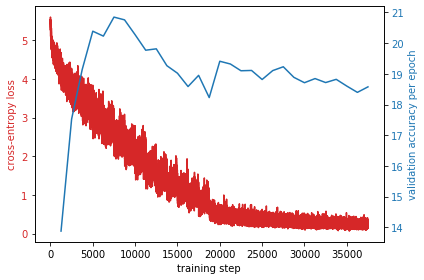

In [46]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('training step')
ax1.set_ylabel('cross-entropy loss', color=color)
ax1.plot(train_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('validation accuracy per epoch', color=color)  # we already handled the x-label with ax1
ax2.plot(x,val_accuracy_per_epoch, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

### Task 3
Distill teacher network with student network, achieve at least +1% improvement in accuracy over student network accuracy.

First, I set up the model as before, but I will train it using the predictions coming from the "cumbersome" model trained and saved in `homework_part2.ipynb`.

In [24]:
teacher = torch.load('cumbersome_model.pth')

#### Define new loss function

In [25]:
def cross_entropy_with_soft_targets(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [26]:
class CrossEntropyLossTemperature_withSoftTargets(torch.nn.Module):
    def __init__(self, temperature, reduction='mean'):
        super(CrossEntropyLossTemperature_withSoftTargets, self).__init__()
        self.T = temperature
        self.reduction = reduction

    def forward(self, input, soft_targets, hard_targets):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        z = input / self.T
        loss_1 = self.T**2*cross_entropy_with_soft_targets(z, F.softmax(soft_targets, 1, _stacklevel=5))
        loss_2 = F.cross_entropy(input, hard_targets, weight=None,
                               ignore_index=-100, reduction=self.reduction)
        
        return loss_1+loss_2

In [27]:
student = nn.Sequential()

student.add_module('conv1', nn.Conv2d(3, 100, kernel_size=(3,3), stride=1))
student.add_module('bn1', nn.BatchNorm2d(100))
student.add_module('relu1', nn.ReLU())
student.add_module('maxpool1', nn.MaxPool2d(3))

student.add_module('flatten', nn.Flatten())
student.add_module('fc1', nn.Linear(40000, 1000))
student.add_module('bn2', nn.BatchNorm1d(1000))
student.add_module('relu2', nn.ReLU())
student.add_module('dp1', nn.Dropout(0.5))
student.add_module('fc2', nn.Linear(1000, 200))

student = student.to(device)
loss_fn = CrossEntropyLossTemperature_withSoftTargets(1)

#L2 regularization is added through weight_decay
optimizer = torch.optim.Adam(student.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [28]:
def distill_knowledge(teacher,val_accuracy
                      student,
                      train_loader,
                      val_loader,
                      optimizer,
                      num_epochs,
                      scheduler = None):

    teacher.train(False)   
    for epoch in range(num_epochs):
        student.train(True) 
        start_time = time.time()
        for x_batch, y_batch in train_loader:
            
            # I. Training
            #1 Train on GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            #2 Clear the gradients
            optimizer.zero_grad()
            
            #3 Forward
            predictions_teacher = teacher.forward(x_batch)
            predictions_student = student.forward(x_batch)
            
            #4 Calculating loss
            loss = loss_fn(predictions_student, predictions_teacher, y_batch)
            
            #5 Calculating gradients
            loss.backward()

            #6 Optimizer step
            optimizer.step()
            
            # II. Tracking the training
            train_loss.append(loss.cpu().data.numpy())  
        
        if scheduler:
            scheduler.step()
        # III. Validation
        student.train(False) # disable dropout / use averages for batch_norm
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            predictions_student = student.forward(x_batch)
            y_pred = predictions_student.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        validation_accuracy = np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100
        # IV. Reporting
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(train_dataset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            validation_accuracy))
        
        if validation_accuracy > 24:
            print(f'Fitted the model to exceed 24% on the validation set.Exiting loop on epoch {epoch + 1}.')
            break

In [29]:
train_loss = []
val_accuracy = []
distill_knowledge(teacher, student, train_loader, val_loader, optimizer, 100, scheduler = scheduler)

Epoch 1 of 100 took 123.992s
  training loss (in-iteration): 	8.938258
  validation accuracy: 			16.54 %
Epoch 2 of 100 took 124.184s
  training loss (in-iteration): 	7.694273
  validation accuracy: 			20.11 %
Epoch 3 of 100 took 124.379s
  training loss (in-iteration): 	7.056781
  validation accuracy: 			21.85 %
Epoch 4 of 100 took 124.174s
  training loss (in-iteration): 	6.610803
  validation accuracy: 			23.08 %
Epoch 5 of 100 took 124.029s
  training loss (in-iteration): 	6.226841
  validation accuracy: 			23.47 %
Epoch 6 of 100 took 124.229s
  training loss (in-iteration): 	5.899975
  validation accuracy: 			23.86 %
Epoch 7 of 100 took 124.178s
  training loss (in-iteration): 	5.591008
  validation accuracy: 			23.30 %
Epoch 8 of 100 took 124.259s
  training loss (in-iteration): 	5.309193
  validation accuracy: 			23.96 %
Epoch 9 of 100 took 123.999s
  training loss (in-iteration): 	5.057131
  validation accuracy: 			23.83 %
Epoch 10 of 100 took 123.924s
  training loss (in-itera

Actually, the results are pretty amazing. To be sure, let's check on the test dataset:

In [30]:
class TestDataset(Dataset):
    def __init__(self, root_folder, labels_frame, class_to_idx, transform=None):

        self.transform = transform
        self.root_folder = root_folder
        self.labels_frame = labels_frame
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.labels_frame) - 1
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_folder,
                                self.labels_frame.loc[idx, 'imname'])
        image = io.imread(img_name)
        
        # Treating greyscale images
        if len(image.shape) < 3:
            image = skimage.color.grey2rgb(image, alpha=None)

        if self.transform:
            image = self.transform(image)
        category = self.class_to_idx[self.labels_frame.loc[idx, 'id']]
        return image, category

In [31]:
labels = pd.read_csv('tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None)
labels.columns = ['imname', 'id', 'bb1', 'bb2', 'bb3', 'bb4']
class_to_idx = dataset.class_to_idx
test_dataset = TestDataset(root_folder='tiny-imagenet-200/val/images/',
                           labels_frame=labels,
                           class_to_idx=class_to_idx,
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                           ]))
test_loader = torch.utils.data.DataLoader(test_dataset, 
                            batch_size=10,
                            shuffle=True,
                            num_workers=1)

student.train(False)
correct_samples = 0
total_samples = 0
for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    predictions = student.forward(x_batch)
    y_pred = predictions.max(1)[1].data
    correct_samples += torch.sum(y_pred == y_batch)
    total_samples += y_batch.shape[0]
test_accuracy = float(correct_samples) / total_samples
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

Final results:
  test accuracy:		23.98 %


### TL;DR. Moar techniques on accuracy vs time trade-off (just for your information)

### Tensor type size

One of the hyperparameter affecting memory consumption is the precision (e.g. floating point number). The most popular choice is 32 bit however with several hacks* 16 bit arithmetics can save you approximately half of the memory without considerable loss of perfomance. This is called mixed precision training.

*https://arxiv.org/pdf/1710.03740.pdf

### Quantization

We can actually move further and use even lower precision like 8-bit integers:

* https://heartbeat.fritz.ai/8-bit-quantization-and-tensorflow-lite-speeding-up-mobile-inference-with-low-precision-a882dfcafbbd
* https://nervanasystems.github.io/distiller/quantization/
* https://arxiv.org/abs/1712.05877

### Pruning

The idea of pruning is to remove unnecessary (in terms of loss) weights. It can be measured in different ways: for example, by the norm of the weights (similar to L1 feature selection), by the magnitude of the activation or via Taylor expansion*.

One iteration of pruning consists of two steps:

1) Rank weights with some importance measure and remove the least important

2) Fine-tune the model

This approach is a bit computationally heavy but can lead to drastic (up to 150x) decrease of memory to store the weights. Moreover if you make use of structure in layers you can decrease also compute. For example, the whole convolutional filters can be removed.

*https://arxiv.org/pdf/1611.06440.pdf